# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

***Variable description***

- occ : occupational classification
- ind : industry classification
- lwage : log hourly wage
- sex : gender (1 female) (0 male)
- shs : some high school
- hsg : High school graduated
- scl : Some College
- clg: College Graduate
- ad: Advanced Degree
- ne: Northeast
- mw: Midwest
- so: South
- we: West
- exp1: experience

### **1.  Analysis in the subset of workers with advanced college education (variables scl, clg, ad).**

Next, we will conduct an analysis for the subset of workers with advanced college education. To do this, we will restrict our data and keep only those who have Some College, College Graduate, or Advanced Degree. 

In particular, the table above shows that the difference in average *logwage* between men and women  with higher education is equal to $0.0750$

Thus, the unconditional gender wage gap is about $7,5$\% for the group of never married workers (women get paid less on average in our sample). 

#### 1.1 OLS estimation without controls

#### 1.2 OLS estimation with controls

Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

#### 1.3 Partialling-Out using ols

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

In the following, we illustrate the partialling-out approach using lasso instead of ols. 

Next, we summarize the results.

Next we try "extra" flexible model, where we take interactions of all controls, giving us about 1000 controls.

### **2.   Descriptive statistics subset of workers with advanced college education (variables scl, clg, ad).**


##### 2.1)  Wage & Lwage

#### 2.2 Descriptive data by gender

### **3. Confidence Interval of sex's coefficient for a different models:**


### **4. Replication of the figure: Experience Profiles and Wage Gap for High School Graduates**


### Now, we will construct a prediction rule for (log) hourly wage **Y**, which depends linearly on job-relevant characteristics **X**:

$$
Y = \beta'X + \epsilon
$$

Our goals are:

- Predict wages using various characteristics of workers.
- Assess the predictive performance of a given model using the (adjusted) sample MSE, the (adjusted) sample $R^2$ and the out-of-sample MSE and $R^2$.

Toward answering the latter, we measure the prediction quality of the two models via data splitting:

1. Randomly split the data into one training sample and one testing sample. Here we just use a simple method (stratified splitting is a more sophisticated version of splitting that we might consider).
2. Use the training sample to estimate the parameters of the Basic Model and the Flexible Model.

Before using the testing sample, we evaluate in-sample fit.


In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data
data = pd.read_csv("../../data/wage2015_subsample_inference.csv")
# Define alpha values for Lasso
alphas = np.linspace(0.1, 0.5, 5)
print(alphas)

[0.1 0.2 0.3 0.4 0.5]


In [20]:
# Split data into training and test sets
np.random.seed(1)
train_indices = np.random.choice(data.index, size=int(len(data) * 0.8), replace=False)
train = data.loc[train_indices]
test = data.drop(train_indices)

# Define categorical variables for future code
categorical_features = ['occ2', 'ind2']
continuous_features = ['sex', 'exp1', 'shs', 'hsg', 'scl', 'clg', 'mw', 'so', 'we', 'exp2', 'exp3', 'exp4']

In [34]:
# Basic model using OLS
formula_basic = 'lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2'
model_basic = smf.ols(formula_basic, data=train).fit()
print("Number of regressors in the basic model:", len(model_basic.params))
print(model_basic.summary())

Number of regressors in the basic model: 12
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     109.2
Date:                Sat, 13 Apr 2024   Prob (F-statistic):          2.86e-219
Time:                        22:24:34   Log-Likelihood:                -2991.7
No. Observations:                4120   AIC:                             6007.
Df Residuals:                    4108   BIC:                             6083.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [35]:
# Flexible model using OLS
formula_flex = 'lwage ~ sex + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'
model_flex = smf.ols(formula_flex, data=train).fit()
print("Number of regressors in the flexible model:", len(model_flex.params))

Number of regressors in the flexible model: 51


In [23]:
# Flexible model using Lasso, in-sample fit
y_train = train['lwage']
X_train = pd.get_dummies(train[features], drop_first=True)
lasso_cv = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)

In [24]:
# Results storage
results = pd.DataFrame({
    'alpha': lasso_cv.alphas_,
    'mse': np.mean(lasso_cv.mse_path_, axis=1),
    'lambda_min': lasso_cv.alpha_,
    'nzero': np.sum(lasso_cv.coef_ != 0)
})

In [25]:
# Display results
results_sorted = results.sort_values(by='mse')
print(results_sorted)

   alpha       mse  lambda_min  nzero
4    0.1  0.282819         0.1      4
3    0.2  0.285540         0.1      4
2    0.3  0.290279         0.1      4
1    0.4  0.292828         0.1      4
0    0.5  0.294752         0.1      4


C:\Users\Josue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Josue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


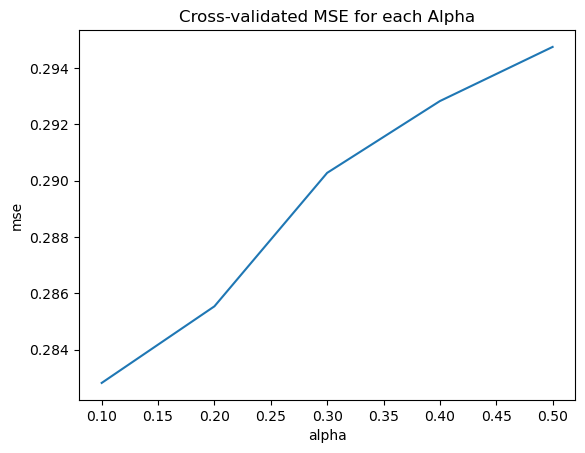

In [26]:
# Plotting the results
sns.lineplot(data=results_sorted, x='alpha', y='mse')
plt.title('Cross-validated MSE for each Alpha')
plt.show()

### Data Splitting: Out-of-sample performance

Now that we have seen in-sample fit, we evaluate our models on the out-of-sample performance:

1. Use the testing sample for evaluation. Predict the **wage** of every observation in the testing sample based on the estimated parameters in the training sample.
2. Calculate the Mean Squared Prediction Error (**MSE<sub>test</sub>**) based on the testing sample for both prediction models.



In [27]:
# Out-of-sample performance
y_test = test['lwage']
X_test = pd.get_dummies(test[features], drop_first=True)

In [28]:
# Basic model
y_hat_test_basic = model_basic.predict(sm.add_constant(X_test))
mse_test_basic = mean_squared_error(y_test, y_hat_test_basic)
r2_test_basic = 1 - mse_test_basic / np.var(y_test)


In [29]:
# Flexible model
y_hat_test_flex = model_flex.predict(sm.add_constant(X_test))
mse_test_flex = mean_squared_error(y_test, y_hat_test_flex)
r2_test_flex = 1 - mse_test_flex / np.var(y_test)

In [30]:
# Lasso model
y_hat_test_lasso = lasso_cv.predict(X_test)
mse_test_lasso = mean_squared_error(y_test, y_hat_test_lasso)
r2_test_lasso = 1 - mse_test_lasso / np.var(y_test)

In [31]:
# Print MSE and R^2
print("Test MSE for the basic model:", mse_test_basic, "Test R2 for the basic model:", r2_test_basic)
print("Test MSE for the flexible model:", mse_test_flex, "Test R2 for the flexible model:", r2_test_flex)
print("Test MSE for the lasso on flexible model:", mse_test_lasso, "Test R2 for the lasso flexible model:", r2_test_lasso)

Test MSE for the basic model: 0.24905335727751943 Test R2 for the basic model: 0.25199179595198007
Test MSE for the flexible model: 0.25385394449047566 Test R2 for the flexible model: 0.2375736862794492
Test MSE for the lasso on flexible model: 0.288337620863549 Test R2 for the lasso flexible model: 0.13400522563005712


# **1.Frisch-Waugh-Lovell (FWL) Theorem Proof**

Given a linear regression model, we aim to demonstrate the FWL theorem using the following elements:

- **$y$**: dependent variable vector ($n \times 1$)
- **$D$**: matrix of independent variables of interest ($n \times k_1$)
- **$\beta_1$**: coefficient vector for $D$ ($k_1 \times 1$)
- **$W$**: matrix of control variables ($n \times k_2$)
- **$\beta_2$**: coefficient vector for $W$ ($k_2 \times 1$)
- **$u$**: error term vector ($n \times 1$)

The model is represented as:

$$ y = D\beta_1 + W\beta_2 + u$$

---

## **Objective**

To prove that $\Psi = \beta_1$ can be accurately estimated through the regression $e_y = e_D \Psi + \varepsilon$, employing the FWL theorem.

---

## **Proof**

### **Step 1: Control for Variables in $W$**

First, we calculate the residuals after controlling for $W$:

- **Regress $D$ on $W$:** Aim to determine the component of $D$ that is orthogonal to $W$. This is achieved by calculating the residuals $e_D$, using the projection matrix:
  
  $$M_W = I - W(W'W)^{-1}W'$$
  
  Thus, the residuals for $D$ are:
  
  $$e_D = M_W D$$ 

- **Regress $y$ on $W$:** Similarly, find the component of $y$ not explained by $W$:
  
  $$e_y = M_W y$$

### **Step 2: Estimate $\Psi$**

With the residuals obtained, we proceed to estimate $\Psi$:

- **Regress $e_y$ on $e_D$ by OLS:** 

  $$ e_y = e_D \Psi + z $$
  
  Solving for $\Psi$, we get:
  
  $$ \hat{\Psi} = (e_D'e_D)^{-1}e_D'e_y $$
  
  Substituting the expressions for residuals into $\hat{\Psi}$ yields:
  
  $$ \hat{\Psi} = (D'M_W'M_W'D)^{-1}D'M_W'M_Wy $$
  
  Which simplifies to:
  
  $$ \hat{\Psi} = (D'M_WD)^{-1}D'M_Wy $$

And this proof that $\Psi = \beta_1$.







# **2.Conditional Expectation Function Minimizes Expected Squared Error Proof**

## **Problem Statement**

Given a random variable $Y$ and a conditioning variable $X$, we consider a relationship of the form:
$$ Y = m(X) + \epsilon $$
where:
- $m(X) = E[Y | X]$ is the Conditional Expectation Function (CEF) of $Y$ given $X$.
- $\epsilon$ is the error term, representing the deviation of $Y$ from its conditional mean.

## **Objective**

Our goal is to prove that the function that minimizes the expected squared error:
$$ m(X) = \text{arg}\min_{g(X)} E[(Y - g(X))^2] $$

is indeed:
$$ E[(Y - g(X))^2] = E[\epsilon^2] $$

## **Proof**

### **Step 1: Expanding the Expected Squared Error**

We start by expanding the expected squared difference as follows:
$$ E[(Y - g(X))^2] = E[(Y - E[Y|X] + E[Y|X] - g(X))^2] $$

By applying the expansion for the square of a sum $(a + b)^2 = a^2 + b^2 + 2ab$, where $a = Y - E[Y|X]$ and $b = E[Y|X] - g(X)$, we obtain:
$$ E[(Y - g(X))^2] = E[(Y - E[Y|X])^2] + E[(E[Y|X] - g(X))^2] + 2E[(Y - E[Y|X])(E[Y|X] - g(X))] $$

### **Step 2: Simplifying Using the Law of Iterated Expectations**

Applying the Law of Iterated Expectations to the mixed term:
$$ 2E[(Y - E[Y|X])(E[Y|X] - g(X))] = 0 $$

This follows because the expectation of $Y - E[Y|X]$ is zero by definition of the error term $\epsilon$ (i.e., $Y - E[Y|X] = \epsilon$ and $E[\epsilon] = 0$), and thus the cross-term disappears.

### **Step 3: Final Reduction**

After removing the cross-term, we are left with:
$$ E[(Y - g(X))^2] = E[(Y - E[Y|X])^2] + E[(E[Y|X] - g(X))^2] $$

Since the second term $E[(E[Y|X] - g(X))^2]$ is always non-negative, it follows that:
$$ E[(Y - g(X))^2] \geq E[(Y - E[Y|X])^2] $$

### **Conclusion**

The expected squared error is minimized when $g(X) = E[Y|X]$, demonstrating that the Conditional Expectation Function (CEF) $m(X)$ minimizes the expected squared error:
$$ m(X) = \text{arg}\min_{g(X)} E[(Y - g(X))^2] $$
This conclusively proves that the CEF is the function that minimizes the expected squared error between the predicted values and the actual values of $Y$.
